# Contour Detection for image segmentation

In previous lessons, we have learned various methods of image segmentation. From thresholding, which converts a gray image into a binary image based on a threshold value to color segmentation where we used OpenCv's `inRange()` function to segment an image according to color/hue in HSV. We will now look at another method known as contour detection. A contour is a curve joining all points of an object.

OpenCV provides a function for this known as `findContours`. One thing to remember is that the object to be found should be white while the background is black. This is because for OpenCV, finding contours is like finding a white object in a black background, as in the [documentation](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html).

Let us get on it.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['image.cmap'] = 'gray'

## The first example

We will look at a simple example, and draw examples from it. We will then go on to other complex examples.

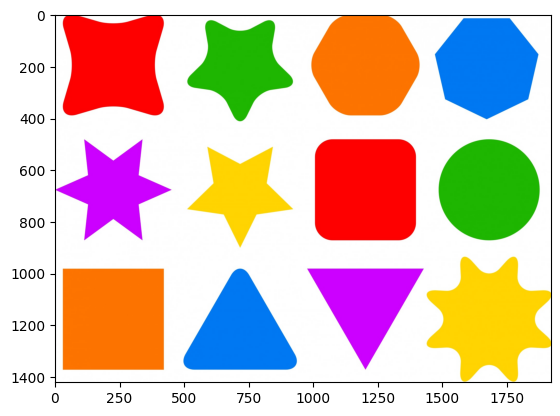

In [93]:
#loading the images
shapes = cv2.imread('images/colourful-shape-icons.jpg')
_ = plt.imshow(shapes[:, :, ::-1])

The next step is to threshold the image.

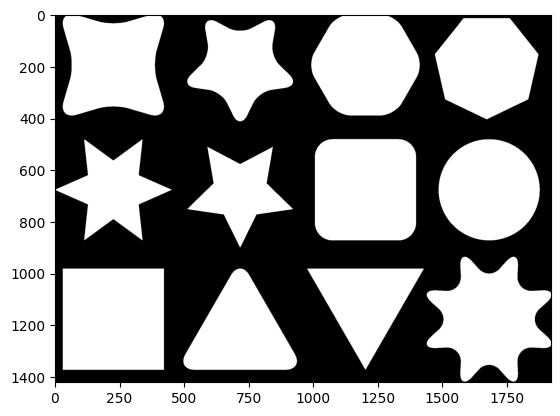

In [94]:
#We now threshold the image
_, bin_shapes = cv2.threshold(cv2.cvtColor(shapes, cv2.COLOR_BGR2GRAY), 220, 255, cv2.THRESH_BINARY_INV)
plt.imshow(bin_shapes)

We will now use this threshold image to find contours. The reason we threshold our image is because the OPenCV function that finds contours `cv2.findContours` (described below) requires this. According to the documentation the function expects a binry image and treats every non-zero pixel in the image as a 1. Also, we use cv2.THRESH_BINARY_INV to make the regions we want to draw contours over white. Simply, the function draws contours over every white region with black as a boundary. Hence the regions we want contours over are white in color.

In [110]:
contours_a, hierarchy_a = cv2.findContours(bin_shapes, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### `findContours`
The function `findContours` returns two objects. One is the contours themselves and the other one is the hierarchy. The contours object tells us the number of contours found and the hierarchy tells us how the contours are arranged.
<br>
Let us look at the number of contours found.

In [111]:
print('No. of contours found:', len(contours_a))

No. of contours found: 12


The above image has 12 contours. This is consistent with what we can see i.e. 12 shapes. The contours object is a tuple. In this case, it contains 12 numpy arrays. Each array gives us the coordinates of each contour.
<br>
Let us examine one.

In [112]:
print(contours_a[0].shape)
contours_a[0]

(659, 1, 2)


array([[[ 974,  983]],

       [[ 975,  984]],

       [[ 975,  985]],

       ...,

       [[1423,  985]],

       [[1423,  984]],

       [[1424,  983]]], dtype=int32)

Here, we see that the first labeled contour is described by 659 (x, y) points.

The **hierarchy** describes how the contours are arranged. Specifically if there are any parent-child relationship between the contours. That is, any contour inside another contour is the child. Let us examine the contours and make a note of them.

In [115]:
print(hierarchy_a.shape)
hierarchy_a

(1, 12, 4)


array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [10,  8, -1, -1],
        [11,  9, -1, -1],
        [-1, 10, -1, -1]]], dtype=int32)

A handy explanation of the hierarchy can be found at this [site](https://learnopencv.com/contour-detection-using-opencv-python-c/). Briefly, however, we see from the shape the number 12, hence the hierarchy information is recorded for every contour. The 4 values recorded are:
``` python
[Next, Previous, First_Child, Parent]
```
As written:
* The next contour in the same hierarchy.
* The previous contour in the same hierarchy.
* The first child.
* The parent.

The last two are -1 in all the rows of the third and fourth colums, since no contour in the image has a child.

### A Note on the parameters

It is also important at this point the parameters used in the `findContours` function as they imapct the number of contours found and the hierarchy structure. Of importance are the second and third required parameters, `mode` and `method`.
<br>
<br>
**mode**
<br>
There are various retrieval modes provided by OpenCV. They describe the contours that should be retrieved by OpenCV and whether or not they should be organized in hierarchy. In this case we have used cv2.RETR_TREE but there are others such as RETR_COMP and RETR_LIST. Information on them can be found [here](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71).
<br>
<br>
In the examples that follow we will see use of another retrieval mode other than the one used here and we will commment why. In this case, we choose this retrieval mode since its as good as any other since this image has no contours.
<br>
<br>
**method**
<br>
This describes the contour approximation method. Simply, how many (x, y) points should be used to describe the image. The most common ones are cv2.CHAIN_APPROX_NONE which does no approximation and stores all points (so, in a rectangle, it would store every point of a rectangle) and cv2.CHAIN_APPROX_SIMPLE which does simple approximations and stores sufficient points to describe the contour (like storing 4 points to describe a rectangle). There are other approximation methods that can be used, they are found [here](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff). 
<br>
<br>
The approximation method chosen affects the number of points that describe a contour. In our case, changing from CHAIN_APPROX_SIMPLE to CHAIN_APPROX_NONE could double the number of points used to describe any contour.

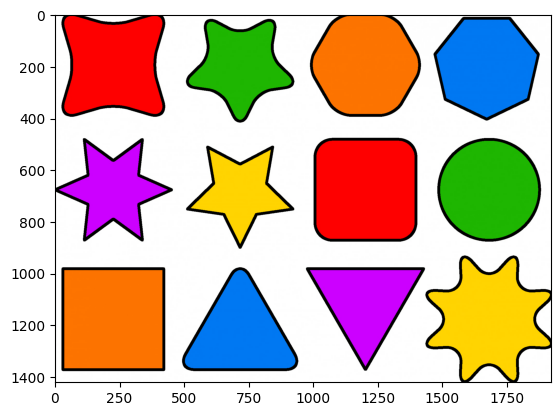

In [126]:
# we now draw
shape_drawn = shapes.copy()
_ = cv2.drawContours(shape_drawn, contours_a, -1, (0, 0, 0), thickness=10)
plt.imshow(shape_drawn[:, :, ::-1])

There we have it. The algorithm easily found the objects and marked out contours over all of them. Before we move on to more challenging problems, let us look at other things we can do with contours. Remember, a contour describes a region, (just like you could slice a region of an array with numpy). We can exploit this fact and pass contours to functions that require a region. For example, the function `boundingRect` creates a bounding rectangle around a region. Let's try some of this.

## Manipulating Contours

### Drawing a bounding rectangle

In [162]:
#We create a utility function to produce various colors
#from hsv to bgr... the value and saturation are kept 
#constant, we only vary the hue
def color_hsv_bgr(hue):
    hsv = np.array([[[hue, 255, 255]]], np.uint8)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return tuple(int(i) for i in bgr[0, 0])

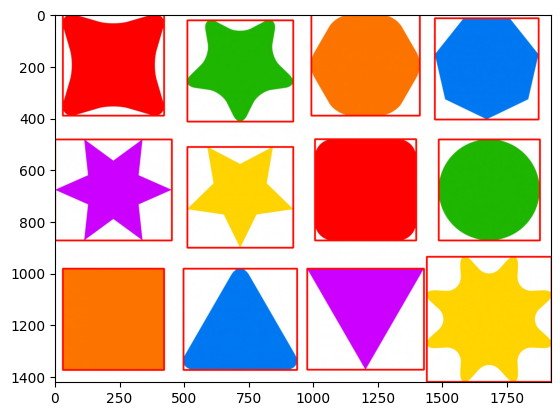

In [180]:
#We iterate through every contour
shapes_rect = shapes.copy()
for cnt_a in contours_a:
    #Create a bounding rectangle around the region
    x, y, w, h = cv2.boundingRect(cnt_a)
    #draw the bounding Rectangle
    cv2.rectangle(shapes_rect, (x, y), (x+w, y+h), color_hsv_bgr(1), thickness=5)

plt.imshow(shapes_rect[:, :, ::-1])

### Minimum Enclosing Circle

We can also do a minimum enclosing circle around our image.

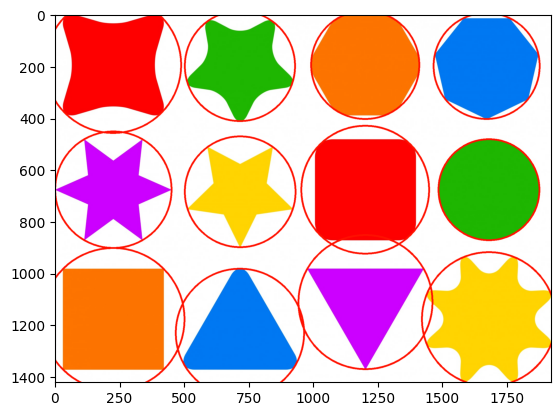

In [184]:
#We iterate through every contour
shapes_circ = shapes.copy()
for cnt_a in contours_a:
    #Find the minimum enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(cnt_a)
    centre = (int(x), int(y))
    #draw the circle
    cv2.circle(shapes_circ, centre, int(radius), color_hsv_bgr(2), thickness=5)

plt.imshow(shapes_circ[:, :, ::-1])

There are many more operations you can do with contours. Some of them can be found [**here**](https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html).

## The Second Example

We are now going to look at another example.

(1204, 1880, 3)

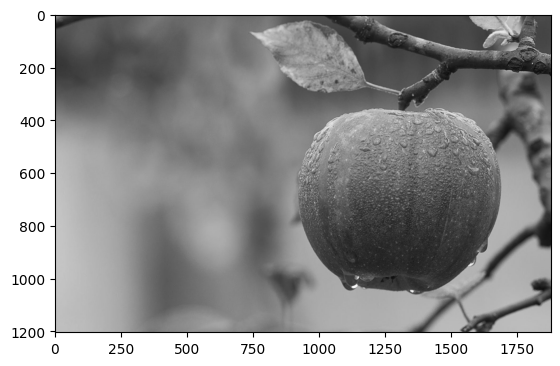

In [185]:
#loading the images
#We will start with a simple image
apple = cv2.imread('images/applegray_detect_contours.jpeg')
plt.imshow(apple)
apple.shape

We convert the image to gray (or, in this case, take any channel of the image as a gray image as they are all the same) and threshold it.

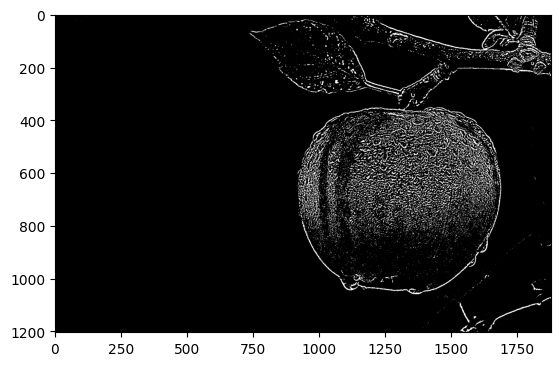

In [186]:
apple_gray = apple[:, :, 0]

apple_thresh = cv2.adaptiveThreshold(apple_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 10)
plt.imshow(apple_thresh)

One thing we note from this image is the fact that we have used adaptive thresholding instead of choosing a threshold value. This is because a single threshold value will not properly capture the apple hence we use adaptive thresholding.

Also, unlike the pervious example we will not directly go into finding contours. As we said, the algoritm `findContours` draws a contour around any closed white region, whether enclosing a black or white region inside. To see how the image would look like if we tried to find ocnoturs as it is, let us dilate it.

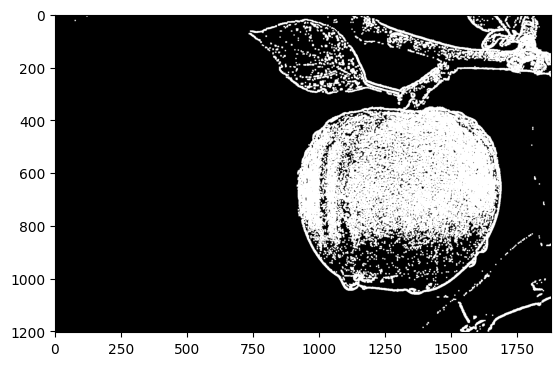

In [192]:
apple_dilate = cv2.dilate(apple_thresh, np.ones((5, 5), np.uint8))
plt.imshow(apple_dilate)

We see that in the image, there are isolated spots of white, one at the upper-most left and others to the right next to the apple. These regions, though small are contours by themselves. We need to remove them if we will have contours over relevant portions of the image. This is a two step process.
<br>
<br>
We will first erode the image to remove these isolated portions. We do not stop here, however, since erosion introduces gaps where we do not want them (along the apple for example). We then dilate the resultant image to close those gaps.

### Step 1: Erosion

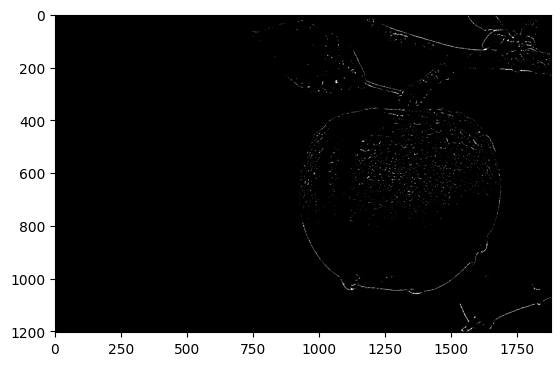

In [217]:
apple_erode = cv2.erode(apple_thresh, np.ones((3, 3), np.uint8), iterations=1)
plt.imshow(apple_erode)

### Step 2: Dilation

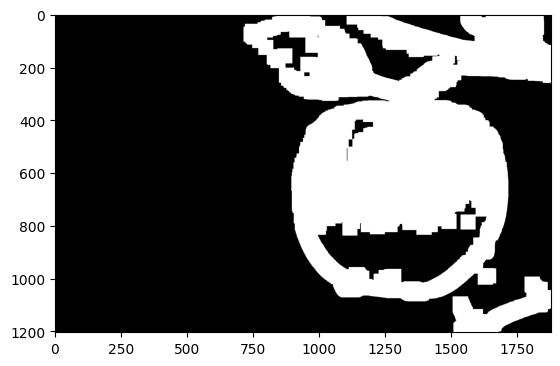

In [221]:
kernel_2 = np.ones((5, 5), np.uint8)
apple_dilate = cv2.dilate(apple_erode, kernel_2, iterations=14)
plt.imshow(apple_dilate)

After the operation we now see that the dilated image has lost many of its unwanted blobs. We can now follow the same process as before to get the contours and draw them.

We will now draw the contours around the original image. We need to use a color image to be able to draw in color.

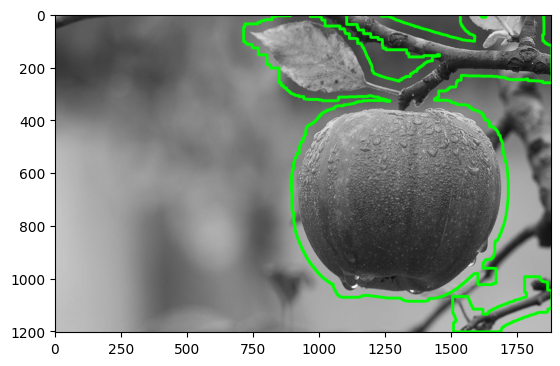

In [224]:
contours_b, hierarchy_b = cv2.findContours(apple_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#We make it a 3-channel image to draw in color
apple_drawn = apple.copy()
apple_drawn = cv2.drawContours(apple_drawn, contours_b, -1, (0, 255, 0), thickness=10)

plt.imshow(apple_drawn[:, :, ::-1])

There we have it, though not perfect, we have been able (with a little tinkering) to draw a contour around the apple.

One thing to note about this example is the choice of retrieval mode. We used the cv2.RETR_EXTERNAL which only returns the external contours and not child contours. Had we chosen, say, to use the cv2.RETR_LIST, it would have drawn contours inside the apple (or in any enclosing white region).

## A final example

Let us now look at another example to let it all sink in.

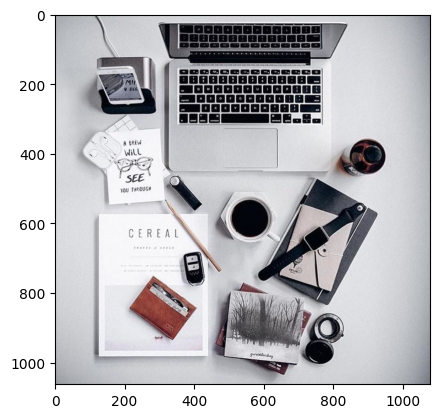

In [225]:
desktop = cv2.imread('images/detect_contour_desk_topview.jpeg', cv2.IMREAD_COLOR)
plt.imshow(desktop[:, :, ::-1])

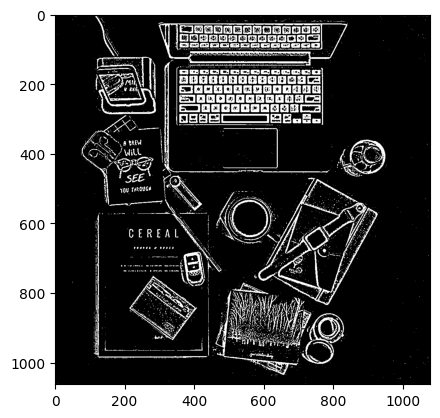

In [13]:
desktop_thresh = cv2.adaptiveThreshold(cv2.cvtColor(desktop, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 10)
plt.imshow(desktop_thresh)

We have also applied an adaptive threshold on this image to bring out the objects. Just as in the previous one, we will use a combination of dilation and erosion to bring out the parts we want to form contours around.

### Step 1: Dilate

Here, we begin by dilating the image to make both the areas we want and the imperfect spots to pop out.

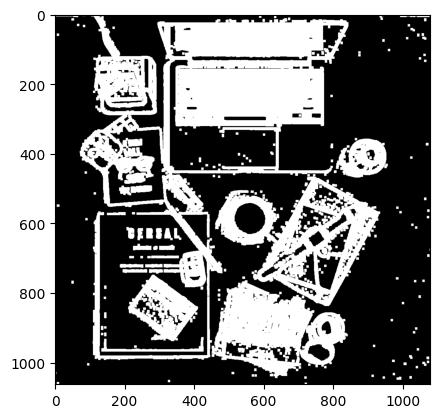

In [261]:
desktop_dilate = cv2.dilate(desktop_thresh, np.ones((7, 7), np.uint8), iterations=1)
plt.imshow(desktop_dilate)

### Step 2: Erode

Next, we erode our image 3 times. We use a `4 x 4` kernel twice to remove the huge individual spots and a smaller `2 x 2` kernel in one iteration to erode smaller sections.

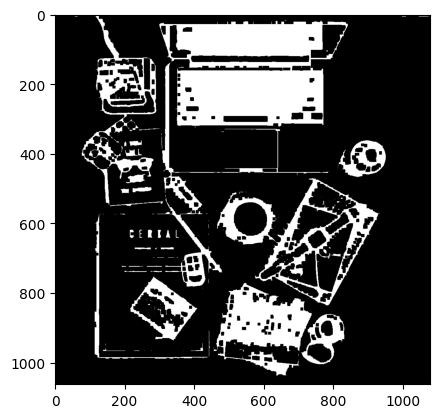

In [262]:
desktop_erode_1 = cv2.erode(desktop_dilate, np.ones((4, 4), np.uint8), iterations=2)
desktop_erode = cv2.erode(desktop_erode_1, np.ones((2, 2), np.uint8), iterations=1)
plt.imshow(desktop_erode)

### Step 3: Dilate

Lastly, we dilate our image to fill all the gaps that erosion had created.

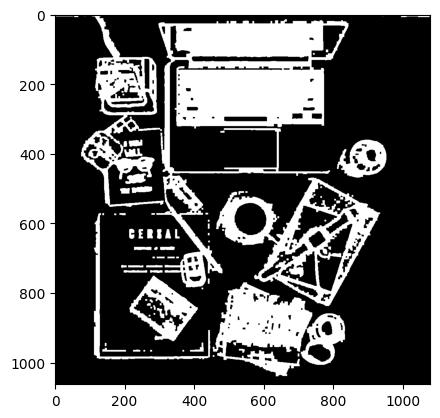

In [263]:
desktop_dilate = cv2.dilate(desktop_erode, np.ones((3, 3), np.uint8), iterations=2)
plt.imshow(desktop_dilate)

Now, as we can see, we no longer have the isolated spots that we had in the threshold image. We can now draw our contours.

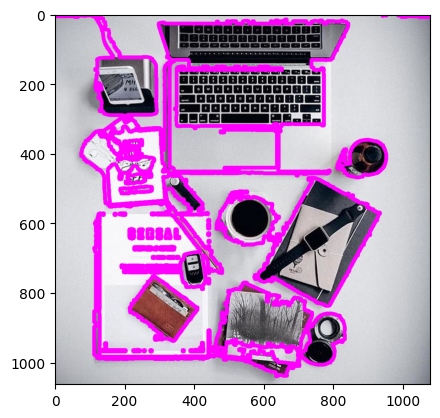

In [266]:
contours_c, hierarchy_c = cv2.findContours(desktop_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

desktop_drawn = desktop.copy()

_ = cv2.drawContours(desktop_drawn, contours_c, -1, (255, 0, 255), thickness=10)
plt.imshow(desktop_drawn[:, :, ::-1])

There we have it. Although not perfect, we can see that atleast contours have been drawn around every major object in the image.

### Recap

To recap, we have seen another image segmentation technique known as contouring. We have seen that a contour is a line drawn around any white enclosing region. If the region is filled, it has no children. If it is not filled, contours can be drawn around the inner white encompassing regions that may be child contours.
<br>
We have also seen how varying the parameters in the `findContours` function can help us to choose which contours to retrieve and also the method of approximation. On top of that, we have seen that there are many functions in opencv that we can use to take advantage of contours including `boundingRect` and `minEnclosingCircle` among others.
<br>
Lastly, it is important to note as we have seen in our last two examples that there is not a one-size-fits-all for all our segmentation needs. As we have seen, we have had to tinker with dilation and erosion to find a suitable binary image.
<br>
That is all for now. We hope that you have enjoyed the article.